# Bottle Client Test

This is a test notebook for the generation of bottle outputs.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

## 1. Generating basic wave

Let's simulate reading every 5 minutes for 24 hours, with `t` in seconds.

In [71]:
MAX_TIME = 24*60*60

In [72]:
t = np.linspace(0, MAX_TIME, MAX_TIME//(5*60))
len(t)

288

In [49]:
def basic_wave(t, consumption):
    return (signal.square(consumption * (2 * np.pi * t) / MAX_TIME)+1) / 2

(-0.1, 1.1)

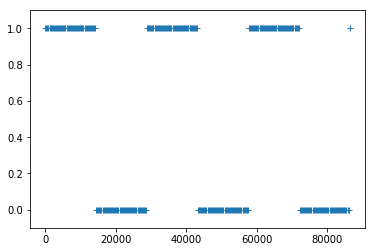

In [50]:
plt.plot(t, basic_wave(t, 3), '+')
plt.ylim(-0.1, 1.1)

## 2. Introducing noise

In [55]:
def noisy_wave(t, consumption, noise=0.05):
    return basic_wave(t, consumption) + np.random.uniform(-noise, noise, t.shape)

(-0.1, 1.1)

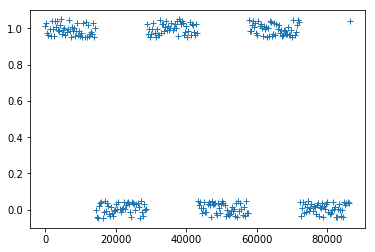

In [56]:
plt.plot(t, noisy_wave(t, 3), '+')
plt.ylim(-0.1, 1.1)

### 3. Introducing random spikes

First lets try to generate just one spike:

In [62]:
def gauss(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2.*sigma**2))

In [113]:
def gauss_spike(x):
    return gauss(x, np.random.uniform(0, MAX_TIME), MAX_TIME / np.random.uniform(50,200))

(-0.1, 1.1)

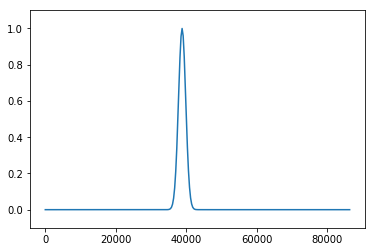

In [114]:
plt.plot(t, gauss_spike(t))
plt.ylim(-0.1, 1.1)

Now, generate n-spikes (`n` random):

In [115]:
def n_gauss_spikes(x):
    n = np.random.randint(2,7)
    result = np.zeros_like(x)
    for i in range(n):
        result += gauss_spike(x)
    return result

(-0.1, 1.1)

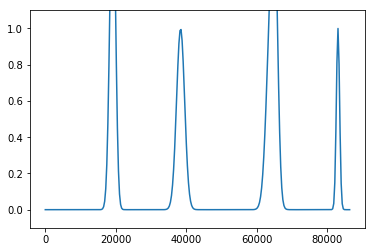

In [117]:
plt.plot(t, n_gauss_spikes(t))
plt.ylim(-0.1, 1.1)

In [118]:
def n_gauss_spikes_noise(x):
    return n_gauss_spikes(x) * np.random.uniform(-1, 1, x.shape)

(-1.1, 1.1)

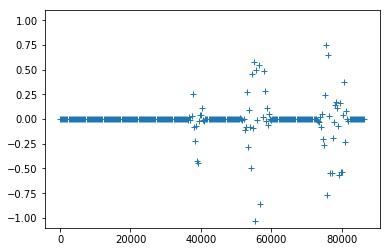

In [119]:
plt.plot(t, n_gauss_spikes_noise(t), '+')
plt.ylim(-1.1, 1.1)

Now let's introduce those spikes into our original wave:

In [120]:
def spikey_wave(t, consumption, noise=0.05):
    return noisy_wave(t, consumption, noise=noise) + n_gauss_spikes_noise(t)

In [127]:
w = spikey_wave(t, 3)

(-1.1, 2)

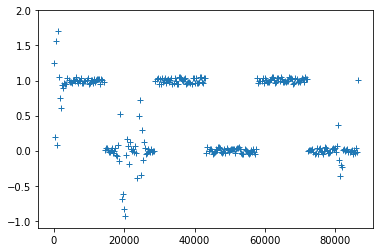

In [128]:
plt.plot(t, w, '+')
plt.ylim(-1.1, 2)

## 4. Testing against the classifier

In [124]:
def find_stable_points(w_raw, var_threshold=0.1, min_stable_samples=3):
    """Return list of stable weight points."""
    run_w = []
    w_stable = []

    for w in w_raw:
        if len(run_w) == 0 or np.var(run_w + [w]) <= var_threshold:
            run_w.append(w)
        else:
            if len(run_w) >= min_stable_samples:
                w_stable.append(np.mean(run_w))
            run_w = [w, ]

    # Insert last
    if len(run_w) >= min_stable_samples:
        w_stable.append(np.mean(run_w))

    return w_stable


def get_consumption(w_stable):
    """Return total consumption value."""
    consumption = 0
    prev_w = None

    for w in w_stable:
        if prev_w is not None and w < prev_w:
            consumption += prev_w - w
        prev_w = w

    return consumption

In [129]:
w_stable = find_stable_points(w)

In [130]:
w_stable

[0.8766694209507367,
 -0.07598216117329352,
 0.06403121659953494,
 0.888290976801577,
 0.10637120524003894,
 0.9025349431832037,
 0.011420024690770398]

In [131]:
get_consumption(w_stable)

2.6256862721780014

Which is very close the original intended consumption value of 3.

## 5. Final generator function

In [142]:
def gen_data(max_time=24*60*60, sample_rate=5, consumption=3, noise=0.05, temperature=20):
    # Aux functions
    def gauss_spike(x):
        mu = np.random.uniform(0, max_time)
        sigma = max_time / np.random.uniform(50,200)
        return np.exp(-(x-mu)**2/(2.*sigma**2))

    t = np.linspace(0, max_time, max_time//(sample_rate*60))
    
    # Basic wave
    w = (signal.square(consumption * 2 * np.pi * t / max_time)+1) / 2
    
    # Add noise
    w += np.random.uniform(-noise, noise, t.shape)
    
    # Generate random spikes
    n_spikes = np.random.randint(2,7)
    spikes = np.zeros_like(t)
    for _ in range(n_spikes):
        spikes += gauss_spike(t)
        
    # Make them noisy
    spikes *= np.random.uniform(-1, 1, t.shape)
    
    # Add noisy spikes to weights
    w += spikes
    
    # Generate temperatures (no need for any randomization)
    temp = np.full_like(t, temperature)
    
    return t, w, temp

In [143]:
gen_data()

(array([    0.        ,   301.04529617,   602.09059233,   903.1358885 ,
         1204.18118467,  1505.22648084,  1806.271777  ,  2107.31707317,
         2408.36236934,  2709.40766551,  3010.45296167,  3311.49825784,
         3612.54355401,  3913.58885017,  4214.63414634,  4515.67944251,
         4816.72473868,  5117.77003484,  5418.81533101,  5719.86062718,
         6020.90592334,  6321.95121951,  6622.99651568,  6924.04181185,
         7225.08710801,  7526.13240418,  7827.17770035,  8128.22299652,
         8429.26829268,  8730.31358885,  9031.35888502,  9332.40418118,
         9633.44947735,  9934.49477352, 10235.54006969, 10536.58536585,
        10837.63066202, 11138.67595819, 11439.72125436, 11740.76655052,
        12041.81184669, 12342.85714286, 12643.90243902, 12944.94773519,
        13245.99303136, 13547.03832753, 13848.08362369, 14149.12891986,
        14450.17421603, 14751.2195122 , 15052.26480836, 15353.31010453,
        15654.3554007 , 15955.40069686, 16256.44599303, 16557.49